# FOILS vs DAGGERBOARDS IN THE OCEANS: a case study through the Vendée Globe 2020/2021


The 2020/2021 edition of the around-the-globe sailing race "Vendée Globe" is historical in that the introduction of foils on 19 out of 33 participants adds a new layer of complexity in the competition. Foils are lateral elements added to the boats that provide a lifting force starting from moderate speed (from roughly 10 kts onwards) and that allow to significantly reduce the water drag of the hull. The new generation of foils seen in this Vendée Globe edition is remarkably efficient in two aspects: on the one hand, they can act like usual daggerboards ("dérives" in French) to reduce lateral leeway and, on the other, they are robust enough to allow the 8/9 tonnes boats to hover on these "mustaches" for long periods and in strong wave conditions. Nevertheless, they come at a price: the incremented speed of the boat and the violent impact that abrupt landings cause to the hull (to the bow, in particular) make these boats much more fragile than older ones endowed with lifting daggerboards. Similarly, the modified sailing balance exerts more important forces on rudders and masts, and these become more fragile as well. Crucially too, this modified balance reduce the ability of foiled boats to advance upwind, preventing the skipper to follow the shortest track should this be (almost) opposite to the direction of the wind.

Hence, although it is physically evident that foiled boats sail faster, the key question is whether they are suited for a race traversing all Oceans, with harsh wave conditions, and strong winds coming from variable directions. With this in mind, what we have *not* tried to do is to predict the winner of the Vendée Globe 2020/2021: this, in our opinion, relies crucially on skipper's ability, varying weather conditions and accidents. We therefore considered the data on the race's website as a rich database for foiled and daggerboards boats sailing in the Ocean with comparable weather conditions, rather than a specific description of a single competition.

As a consequence of this choice, we decided not to use all the data available in the Excel files. For instance, the VMG ("Velocity Made Good"), although being a relevant piece of information in comparing how two specific boats advance with respect to the goal, did not seem to us to faithfully reflect the impact that severe weather conditions can have on foiled boats: indeed, even boats which are relatively close to one other in the global ranking, could be very far apart geographically and could undergo different wind and sea. Moreover, we have not found sufficiently precise weather forecast and wind direction data for the specific analysis we have in mind: to date, all the predictions of the wind direction in the middle of the Atlantic Ocean which we have seen have less precision than 10/15 degrees, and this is too coarse a datum to rely on, for comparing the capacity of a boat to advance upwind. Hence, we considered that although these information say much about how a specific boat is racing against another, they do not convey a global view on how speed's increment afforded by foils balances with longer routes or more stressed boats' structures.

We have therefore decided to focus on three main goals:

1) $\textbf{First analysis: relationship between ranking and presence of foils.}$ An overall comparison of the advantage of foils out of classical daggerboards up to today (three weeks into the race (in the first graph))

2) $\textbf{Second analysis: an algorithm to compute the speed gap according to weather conditions.}$ A comparison on how foils allow for speed increase at comparable weather conditions: this is detailed in paragraph number 2). We refer to its description for more details on how we develop and used an algorithm of division into groups of nearest boats at the time t and linear regression to compare the speed of boats with foils and boats without foils.

3)$\textbf{ Third analysis: impact of foils on the route.}$ An analysis of how different the tracks for foiled and non-foiled boats are, and how this affects the overall ranking outcome (last graph).

All data are downloaded and processed live from the race's website (which is updated six times per day) each time the program is run, and the program will therefore provide more and more precise information as the race goes on.

Our analysis so far leads us to the conclusion that when sailing in the Ocean foiled boats are slightly more efficient than classical daggerboards, but far less than it would be imaginable by simply considering the enormous loss in water drag. We detail our conclusions in the closing remarks of this file.

## 0) Extraction and cleaning of data

### Extraction and cleaning of the technical file with boats information

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from geopy import distance
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns 

In [2]:
def get_soup_from_url(url):
    """It gets a soup from an url"""
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    return soup

In [3]:
info_skipper= "https://www.vendeeglobe.org/fr/glossaire"
soup = get_soup_from_url(info_skipper)

We import the data of the boats and the skippers, we do some basic cleaning, also erasing some information useless for our analysis and we put these information in a dataframe denoted df.

In [4]:
rows = []
for tag in soup.find_all("div", attrs={'class': 'sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6'}):
    row ={}
    row["Skipper name"]=tag.find("span", attrs = {"class": "boats-list__skipper-name"}).text
    row["Boat name"]=tag.find("h3", attrs = {"class": "boats-list__boat-name"}).text
    lista= tag.find_all("li")
    if lista[0].text.split(":")[1][1:]== "Verdier":
        row["Numéro de voile"]="FRA 59"
        for i in [1,2,3,4,5,6,7,8,10,11]:
            row[lista[i].text.split(":")[0][:-1]]=lista[i].text.split(":")[1][1:]     
    elif len(lista) == 14:
        for i in [0,3,4,5,6,7,8,9,10,12,13]:
            row[lista[i].text.split(":")[0][:-1]]=lista[i].text.split(":")[1][1:]
    elif len(lista) == 13:
        for i in [0,2,3,4,5,6,7,8,9,11,12]:
            row[lista[i].text.split(":")[0][:-1]]=lista[i].text.split(":")[1][1:]
    elif len(lista) == 12:
        for i in [0,2,3,4,5,6,7,8,9,10,11]:
            row[lista[i].text.split(":")[0][:-1]]=lista[i].text.split(":")[1][1:]    
    rows.append(row)   
df = pd.DataFrame(rows)   

We check that there are no null values in our dataframe. 

In [5]:
df.isnull().values.any()

False

We define a funtion clean_fiche_tecnique(df) which drops some columns of our dataframe and does some cleaning. Tha data we keep are: Skipper name, Boat name, Date de lancement, Nombres de dérives, Surface de voiles au près, Surface de voiles au portant. Therefore we create a dataframe with only these columns. We have decided not to consider Longuer, Largeur, Tirant d'eau, Hauteur mât as important information beacuse they are very close values for each boat. Since in the column Déplacemenent (poids) there are some unknown values, we have decided to drop also this column. We noticed that the column Numéro de voile is not cleaned. Since this column is present (in a clean form) in the excel files that we are going to analyse later, we drop this colum. The very important feature for our analysis is "Nombre de dérives". The data in the column are not clean. To clean the information we create a new column entitled "Foils/Dérives" and which has "D" if the boat has only daggerboards and "F" if the boat has foils .


In [6]:
def clean_fiche_tecnique(df):
    """It takes a dataframe and returns a cleand dataframe"""

    df=df[["Skipper name", "Boat name", "Date de lancement",'Nombre de dérives', "Surface de voiles au près", "Surface de voiles au portant"]]
    df = df.rename(columns={'Nombre de dérives': "Foils/Dérives"})
    df["Foils/Dérives"]=df["Foils/Dérives"].replace(regex='foils', value= 'F')

    df["Foils/Dérives"]=df["Foils/Dérives"].replace(regex='2 asymétriques', value= 'D')
    df["Foils/Dérives"]=df["Foils/Dérives"].replace(regex='2', value= 'D')
    df["Foils/Dérives"]=df["Foils/Dérives"].replace(regex='foiler', value= 'F')
    #The capital letter of the names are only the first
    df["Skipper name"]=df["Skipper name"].apply(lambda x: x.title())
    #These three skippers are called differently in the excel files, soo I correct the names here. 
    df.loc[24,"Skipper name"]='Alan Roura'
    df.loc[5,"Skipper name"]='Arnaud Boissieres'
    df.loc[11,"Skipper name"]='Samantha Davies'
    return df

Now we look at our cleand dataframe.

In [7]:
df=clean_fiche_tecnique(df)
df


,Skipper name,Boat name,Date de lancement,Foils/Dérives,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,NEWREST - ART & FENÊTRES,01 Août 2015,F,320 m2,570 m2
1,Romain Attanasio,PURE - Best Western®,08 Mars 2007,D,280 m2,560 m2
2,Alexia Barrier,TSE - 4MYPLANET,01 Mars 1998,D,260 m2,580 m2
3,Yannick Bestaven,Maître CoQ IV,12 Mars 2015,F,310 m2,550 m2
4,Jérémie Beyou,CHARAL,18 Août 2018,F,320 m2,600 m2
5,Arnaud Boissieres,LA MIE CÂLINE - ARTISANS ARTIPÔLE,03 Août 2007,F,300 m²,610 m²
6,Louis Burton,BUREAU VALLEE 2,09 Juin 2015,F,300 m2,600 m2
7,Didac Costa,ONE PLANET ONE OCEAN,02 Février 2000,D,240 m2,470 m2
8,Manuel Cousin,GROUPE SÉTIN,02 Février 2007,D,270 m2,560 m2
9,Clarisse Cremer,BANQUE POPULAIRE X,01 Mars 2011,D,340 m2,570 m2


In [8]:
foils = df.loc[df["Foils/Dérives"]=="F"]
print("The number of boats with foils is " + str(foils.shape[0]))

The number of boats with foils is 19


In [9]:
derives = df.loc[df["Foils/Dérives"]=="D"]
print("The number of boats with daggerboards is " + str(derives.shape[0]))

The number of boats with daggerboards is 14


### Extraction of data from the excel files with rankings and cleaning of the data.

Now we extract the name of the excels files, their url's and we put them in a list, called list_of_files_excel.

In [10]:
#get a soup from the web-page of ranking
big_page= get_soup_from_url("https://www.vendeeglobe.org/fr/classement")

#find all the numbers for the files, they are attribute of <option, value="number">, except the fist one which has value=""
option = big_page.find_all('option')
#we create a list with all the numbers
#we do not condider the last file because it is full of nan, there is not speed, no ranking, as it is normal it is
#They were just starting
list_of_numbers =[]
for i in option[1:len(option)-1]:
    list_of_numbers.append(i.attrs["value"])
#Here we construct a list of all the url of the files excel

list_of_files_excel= []
for i in list_of_numbers:
    name_file = f'https://vendeeglobe.org/download-race-data/vendeeglobe_{i}.xlsx'
    list_of_files_excel.append(name_file)
       
   

We now write a function that takes one of the url written above, and produces a dafaframe, it also adds to this a column "Time"
putting it in the datatime format.


In [11]:
def create_df_from_excel(name_file):
    """It takes a string of characters (url of an excel file) as argument and 
    returns the dataframe associated to the url.
    It also add to this a column "Time" putting it in the datatime format. """
    data_frame_excel=pd.read_excel(name_file, header=4)
    data_frame_excel["Time"]=name_file[-20:-5]
    data_frame_excel["Time"]=pd.to_datetime(data_frame_excel["Time"], format= "%Y%m%d_%H%M%S")
    return data_frame_excel   

We now write a function that takes a dataframe and do some cleaning. 


In [12]:
def dms2decpd(s):
    """It takes a string of charachetrs of the type 13°22.87'W and returns 
    a signed decimal, it will be used to convert the latitude and the longitude, 
    this function can be used also if there is a Nan, is there is a Nan, which is a float, returns a Nan.
    """
    if type(s)==float:
        dec = s
    else:    
        lis=s.replace("°", ".").replace("'", ".").split(".")
        if lis[3] == "E" or lis[3] =='N':
            dec = int(lis[0]) + int(lis[1])/60 + int(lis[2]) /3600
        else:
            dec= -(int(lis[0]) + int(lis[1])/60 + int(lis[2]) /3600)
    return dec

def clean_dfexcel(data_frame_excel):
    
    """It takes a dataframe and returns a clean dataframe.
    The cleaning path is described in the comments.
    """
    data_frame_excel = data_frame_excel.drop([33,34,35,36], axis =0)
    data_frame_excel = data_frame_excel.drop('Unnamed: 0', axis =1)
    #rename the columns
    data_frame_excel.columns = ['Rank', 'Numéro de voile', 'Nom', 'Heure in FR', 'Latitude', 'Longitude', 'Cap 30min', 'Vitesse 30 min',\
              'VGM 30 min', 'Distance 30 min','Cap dernier', 'Vitesse dernier', 'VGM dernier', 'Distance dernier',\
              'Cap 24 hours', 'Vitesse 24 hours', 'VGM 24 hours', 'Distance 24 hors', 'DTF', 'DTL', "Time"]
    #split Nom  into Skipper name and Boat name and drop the column "Nom"
    data_frame_excel["Skipper name"] = data_frame_excel["Nom"].apply(lambda x: x.split('\n')[0])
    data_frame_excel["Boat name"] = data_frame_excel["Nom"].apply(lambda x: x.split('\n')[1])
    data_frame_excel = data_frame_excel.drop("Nom", axis=1)
    #reorder the columns 
    data_frame_excel= data_frame_excel[['Rank', 'Numéro de voile', "Skipper name", 'Boat name', 'Heure in FR', 'Latitude', 'Longitude', 'Cap 30min', 'Vitesse 30 min',\
              'VGM 30 min', 'Distance 30 min','Cap dernier', 'Vitesse dernier', 'VGM dernier', 'Distance dernier',\
              'Cap 24 hours', 'Vitesse 24 hours', 'VGM 24 hours', 'Distance 24 hors', 'DTF', 'DTL', "Time"]]
    #eliminate "\n" in some columns
    data_frame_excel["Heure in FR"]=data_frame_excel["Heure in FR"].replace(regex='\n', value= '')
    data_frame_excel["Numéro de voile"]=data_frame_excel["Numéro de voile"].replace(regex='FR\n', value= '')
    data_frame_excel["Numéro de voile"]=data_frame_excel["Numéro de voile"].replace(regex='\n', value= '')
    #change of column Latitude and Longitude into decimal
    data_frame_excel["Latitude"]=data_frame_excel["Latitude"].apply(lambda x : dms2decpd(x))
    data_frame_excel["Longitude"]=data_frame_excel["Longitude"].apply(lambda x : dms2decpd(x))
    #replace all the character whcih are not numeric 33 in rank, when a skipper is retired we put is as last 
    #sometimes there is also NL, we put it aslo at last 
    data_frame_excel['Rank'] = data_frame_excel["Rank"].str.replace(r"[a-zA-Z]+",'33')
    data_frame_excel['Rank'] = data_frame_excel["Rank"].str.replace('','')
    #data_frame_excel=data_frame_excel.replace("RET", "33")
    #change the rank to numeric
    data_frame_excel["Rank"]=pd.to_numeric(data_frame_excel["Rank"])
    #when there is a Nan in "Latitude" and "Longitude", it means that the skipper retired. Therefore we let him
    #or her have an apéro in the Marais 
    data_frame_excel["Latitude"] =data_frame_excel["Latitude"].fillna(48.864716)
    data_frame_excel["Longitude"] =data_frame_excel["Longitude"].fillna(2.3488)
    #we trasform "Vitesse dernier", "Distance dernier", "DTF" into numeric
    #the column "Distance dernier" in some file is already numeric, so we have to distinguish two cases
    #In the column "DTF" we put instead of NaN the total distance of the race : 24296.6 nm
    #we add the column "DFS" (distance from start) as the difference of T-"DTF", where T is he total lenght of the race  
    data_frame_excel["Vitesse dernier"]=data_frame_excel["Vitesse dernier"].str.replace(r"[a-zA-Z]+",'')
    data_frame_excel["Vitesse dernier"]=pd.to_numeric(data_frame_excel["Vitesse dernier"])
    data_frame_excel["Vitesse dernier"]=data_frame_excel["Vitesse dernier"].fillna(0)
    if data_frame_excel["Distance dernier"].all()==float:
        data_frame_excel["Distance dernier"]=data_frame_excel["Distance dernier"].fillna(0)
    else:
        data_frame_excel["Distance dernier"]=data_frame_excel["Distance dernier"].str.replace(r"[a-zA-Z]+",'')
        data_frame_excel["Distance dernier"]=pd.to_numeric(data_frame_excel["Distance dernier"])
        data_frame_excel["Distance dernier"]=data_frame_excel["Distance dernier"].fillna(0)
    data_frame_excel["DTF"]=data_frame_excel["DTF"].str.replace(r"[a-zA-Z]+",'')
    data_frame_excel["DTF"]=pd.to_numeric(data_frame_excel["DTF"])
    data_frame_excel["DTF"]=data_frame_excel["DTF"].fillna(24296.6) 
    data_frame_excel["DFS"]=24296.6-data_frame_excel["DTF"]
    data_frame_excel=data_frame_excel.drop(["DTF"], axis=1)    
    return data_frame_excel

We now construct a list of dataframes from the list_of_files_excel. It requires some time, to speed up the process,  we parallelise this. 

In [13]:
from multiprocessing.pool import ThreadPool


with ThreadPool() as p:
    try:
        list_of_df_excel = p.map(create_df_from_excel, list_of_files_excel)
    except:
        pass


We now clean the dataframes in the above list with the function clean_dfexcel.

In [14]:
cleaned_dataframes = [clean_dfexcel(i) for i in list_of_df_excel]

### Merging the dataframes coming from the excel files with the dataframe with the tecnical information

We merge each dataframe coming from xlsx files with the technical file of the boats and we put them 
in a list denoted merged_dataframes. For each dataframe we keep only the columns interesting for our analysis.

In [15]:


merged_dataframes =[]
for i in cleaned_dataframes:
    merged_dataframes.append(pd.merge(df, i, left_on='Skipper name',right_on='Skipper name').sort_values(by =["Rank"])[["Skipper name", "Rank", "Foils/Dérives", "Latitude", "Longitude", "Vitesse dernier", "Distance dernier", "DFS", "Time"]])
   
    
    

We now concatenate every dataframe in the list merged_dataframes, putting them in a unique dataframe, denoted big_merged_data.  

In [16]:

big_merged_data_interesting_columns = pd.DataFrame()
for i in merged_dataframes:
    big_merged_data_interesting_columns = big_merged_data_interesting_columns.append(i, ignore_index=True)
   

## 1) First analysis: relationship between ranking and presence of foils.

In the following plot, we see on the x-axis the time and on the y-axis the ranking. A blue point is a boat with foils. 
A red point is a plot without foils. 

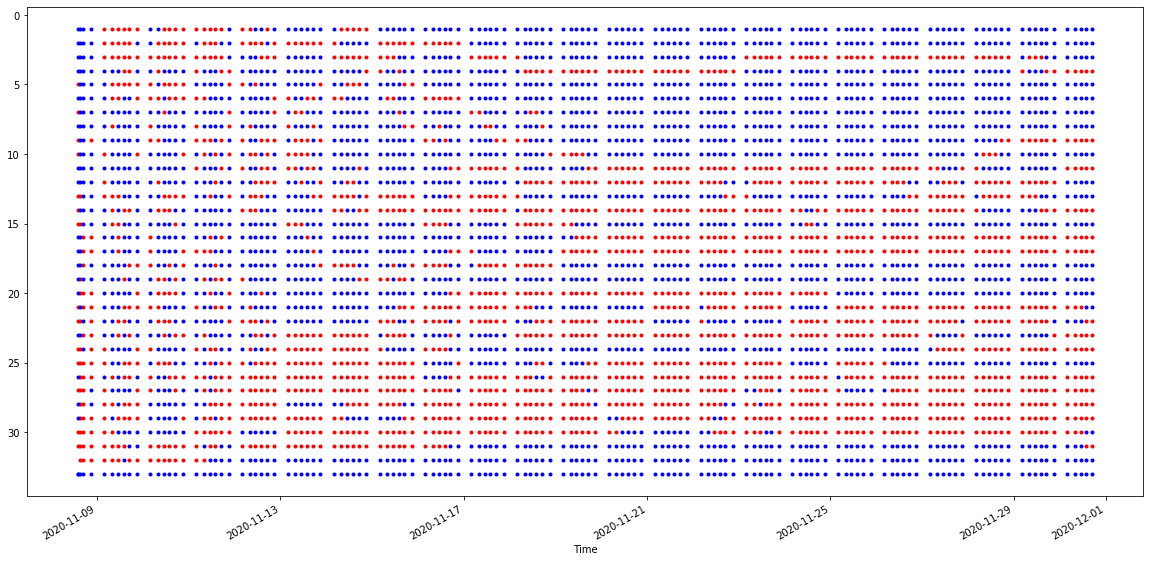

In [17]:
fig = plt.figure(figsize=(20,10))
tab = big_merged_data_interesting_columns.loc[(big_merged_data_interesting_columns['Foils/Dérives'] == 'D')]
tab = tab.set_index('Time')
tab['Rank'].plot(style = '.', color ='r')

tab = big_merged_data_interesting_columns.loc[(big_merged_data_interesting_columns['Foils/Dérives'] == 'F')]
tab = tab.set_index('Time')
tab['Rank'].plot(style= ".", color = 'b').invert_yaxis();

In this graph we plot, for each available file on the race website (one every four hours) the ranking of foiled (blue) and daggerboards (red) boates. It shows that among the first 7/8 participants, as of November the 30th, only one has a classical boat, all the others having foils. Down in the ranking, though, the situation is much less polarized, and foiled and daggerboards boats distribute evenly. The last, in the ranking, are foiled boats, reflecting that, as of November the 30th the only boats that have encountered serious damage have foils.  

## 2) Second analysis: an algorithm to compute speed gap according to weather conditions.


For each xlsx files, we divide all boats into groups. Two boats are in the same group when their distance is less than 100 nautical miles. We chose this distance because we consider that in this range weather conditions are homogeneous and performances are comparable. To determine the group we use the geopy.distance.distance() function, since as the fleet sails southwards, approximation with Euclidean distance becomes less and less precise. We discard groups where only one type of boats (F or D) is present, because we will use groups to compare the speeds of boats with foils and without. The next three functions are used in the algorithm: details about the algorithm are in the cell after the three functions. 

In [18]:
def group_index_mixed(n,t, d = 100):
    """It takes as input two integers n, t, and one parameter
    that by default is equal to 100 nautical miles and
    returns the index of all boats which at time t (0= more recent time)
    have distance less or equal to d from from the boat with index n
    For the group which have only one element of whcih are done only 
    by F or only by D it return a list with a single value 
    
    """
    
    a=merged_dataframes[t]
    coordinates0 = a.at[n, "Latitude"],a.at[n, "Longitude"]
    group =a.loc[a.apply(lambda x: distance.distance(coordinates0, (x["Latitude"],x["Longitude"])).nm, axis=1)<=d]
    res = None
    if group.shape[0]==1:
        res = ["VendeeGlobe2020"]
    elif group[group["Foils/Dérives"]=="F"].shape[0]== 0: 
        res = ["VendeeGlobe2020"]
    elif group[group["Foils/Dérives"]=="D"].shape[0]== 0:    
        res = ["VendeeGlobe2020"]
    else:
        res = group.index
    
    return res
    

In [19]:
def distinct_groups_mixed(t, d=100):
    """
    It takes as imput an integer t and one parameter that by default is equal to 100 nautical miles and
    returns the set of sets of all the group index at the instant t.
    It does not consider the group in which there is a single element. 
    Also since is a set of sets it considers only distinct groups.
    """
    l_o_g=set()
    
    for i in range(0,33):
        g = frozenset(group_index_mixed(i,t,d))
        if len(g)==1:
            pass
        else:
            l_o_g.add(g)
    
        
    
    return l_o_g

In [20]:
def list_of_mixed(t, d=100):
    """
    It takes as input an integer t and one parameter that by default is equal to 100 nautical miles and
    returns at the time t a list of pairs. Each pair contains the mean of the speed of the group and the gap between
    the mean speed of the boats in the group which have foils and the mean speed of the 
     boats in the group which do not have foils
    """
    l_o_g=[]
    groups=distinct_groups_mixed(t,d)
    for group in groups: 
        a=merged_dataframes[t]
        selection = a.loc[group]
        mean= selection["Vitesse dernier"].mean()
        mean_F =selection.loc[selection["Foils/Dérives"]=="F"]["Vitesse dernier"].mean()
        mean_D =selection.loc[selection["Foils/Dérives"]=="D"]["Vitesse dernier"].mean()
        gap = mean_F-mean_D
        pair =(mean, gap)
        l_o_g.append(pair)
        
           
    return l_o_g        

For each xlsx file t, distinct_group_mixed(t) returns the groups at time t, expressed as the indexes of the boats present in each group. Then, the function list_of_mixed(t) at the time t computes a list of pairs (mean, gap) one for each group. Here mean is the average speed of all boats in the group and gap is the gap between the average speed of boats with foils and the average speed of boats without.

We now create a list (list_of_speed) putting toghether all the above pairs.

Be careful: the next cell (as of today, November 30th) takes ca. 200 seconds to run.

In [21]:

list_of_speed=[]
for i in range(0, len(merged_dataframes)-1):
    list_of_speed.append(list_of_mixed(i))


    
               

Now we plot the result of our algorithm. A point in the plot below corresonds to a pair (mean, gap) at the instant t for a group g, where, as explained above, mean is the average speed of the group and the gap is the difference between the average speed of the boats with foils and the boats witouth. We also plot the linear regression line with respect to these points.  

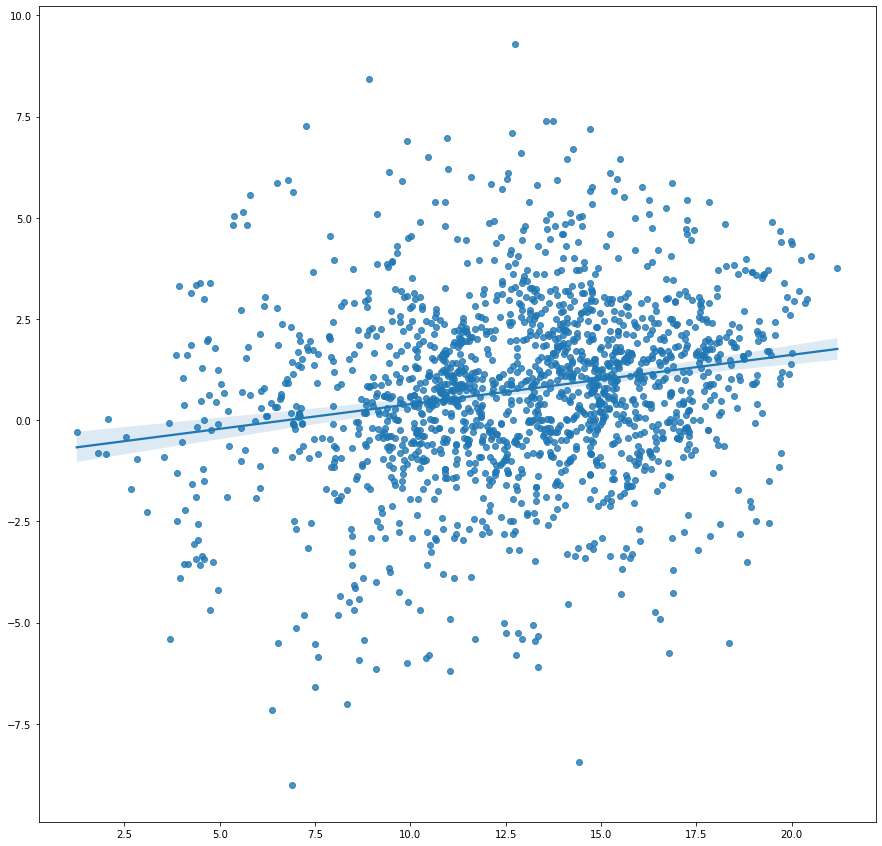

In [22]:
flat_list = []
for sublist in list_of_speed :
    for item in sublist:
        flat_list.append(item)
fig = plt.figure(figsize=(15,15))
x, y = zip(*flat_list)
sns.regplot(x, y)
plt.show()

This graph came to us as a surpise. Our expectation was that the advantage of foils would be less important as the sea conditions deteriorate. The average speed of all boats in a group could be considered as reflecting the strenght of the wind and hence to indicate bigger waves. Therefore we expected that to a larger average speed, the speeds of foiled and classical boats would become closer and closer. In fact we wondered if around 20 kts of average speed, boats without foils could become more efficient than boats with foils. The plot with the linear regression, shows that this is not the case. Indeed the line which best approximates the points has a positive slope. This means that at a larger average speed the speed gap between foiled and classical boats becomes larger. Yet, this slope is small and indeed the linear regression line is almost horizontal, meaning that the speed gap is almost costant. In conclusion the average speed (the wind speed) does not have a significant impact on how foils change the performace of the boat. 

## 3) Third analysis: impact of foils on the route. 


Now we want to analyse the difference of the tracks between the boats with foils and the boats without foils. 

We create a dataframe, denoted gouped, with a column  "TDW" containg the total distance on water traveled by each boat since the beginning of the race. 

In [23]:
grouped =big_merged_data_interesting_columns.groupby(['Skipper name'])["Distance dernier"].sum().reset_index()
grouped = grouped.rename(columns ={"Distance dernier":"TDW"})

grouped.sort_values("TDW")

,Skipper name,TDW
24,Nicolas Troussel,5274.3
29,Sébastien Destremau,7449.3
3,Ari Huusela,7563.7
19,Kojiro Shiraishi,7626.2
2,Alexia Barrier,7728.1
23,Miranda Merron,7746.3
10,Clément Giraud,7815.4
13,Fabrice Amedeo,8064.9
17,Jérémie Beyou,8226.7
12,Didac Costa,8341.6


We consider a dataframe with the column "DFS" containing the distance from the start of the race, computed along the shortest possible route between the position of the boat now and the staring point. In this case we drop all the retired boats, because their data are not relevant for our study.

In [24]:
m=merged_dataframes[0][["Skipper name", "Rank", "DFS","Foils/Dérives"]]
m=m.loc[~(m["DFS"]==0)]
m

,Skipper name,Rank,DFS,Foils/Dérives
10,Charlie Dalin,1,6649.5,F
25,Thomas Ruyant,2,6407.8,F
14,Kevin Escoffier,3,6338.9,F
20,Jean Le Cam,4,6338.0,D
6,Louis Burton,5,6338.0,F
3,Yannick Bestaven,6,6331.6,F
28,Sébastien Simon,7,6293.7,F
17,Boris Herrmann,8,6263.0,F
26,Damien Seguin,9,6194.6,D
23,Giancarlo Pedote,10,6140.9,F


Now we merge the above two dataframes, adding a column "GbD" which contains the gap between the travelled and the optimal distance of each boat. 

In [25]:
m_plus_grouped =pd.merge(m, grouped, left_on='Skipper name',right_on='Skipper name').sort_values(by =["Rank"])
m_plus_grouped["GbD"]=m_plus_grouped["TDW"]-m_plus_grouped["DFS"]
m_plus_grouped.sort_values(by =["GbD"])


,Skipper name,Rank,DFS,Foils/Dérives,TDW,GbD
3,Jean Le Cam,4,6338.0,D,9976.8,3638.8
30,Sébastien Destremau,31,3726.0,D,7449.3,3723.3
13,Maxime Sorel,14,6021.6,D,9794.4,3772.8
12,Isabelle Joschke,13,6067.5,F,9857.0,3789.5
26,Alexia Barrier,27,3933.2,D,7728.1,3794.9
28,Ari Huusela,29,3761.9,D,7563.7,3801.8
15,Romain Attanasio,16,5802.7,D,9632.8,3830.1
10,Benjamin Dutreux,11,6129.9,D,9965.2,3835.3
27,Miranda Merron,28,3905.8,D,7746.3,3840.5
8,Damien Seguin,9,6194.6,D,10038.6,3844.0


The following graph is a representation of how foils prevent the skipper from choosing the optimal theoretical track.
A point in the following graph is a boat . The x-axis represents the gap between the travelled and the optimal distance ("GbD") of the boat and the y-axis the ranking at this moment. A point is blue if the boat has foils and it is red if not.

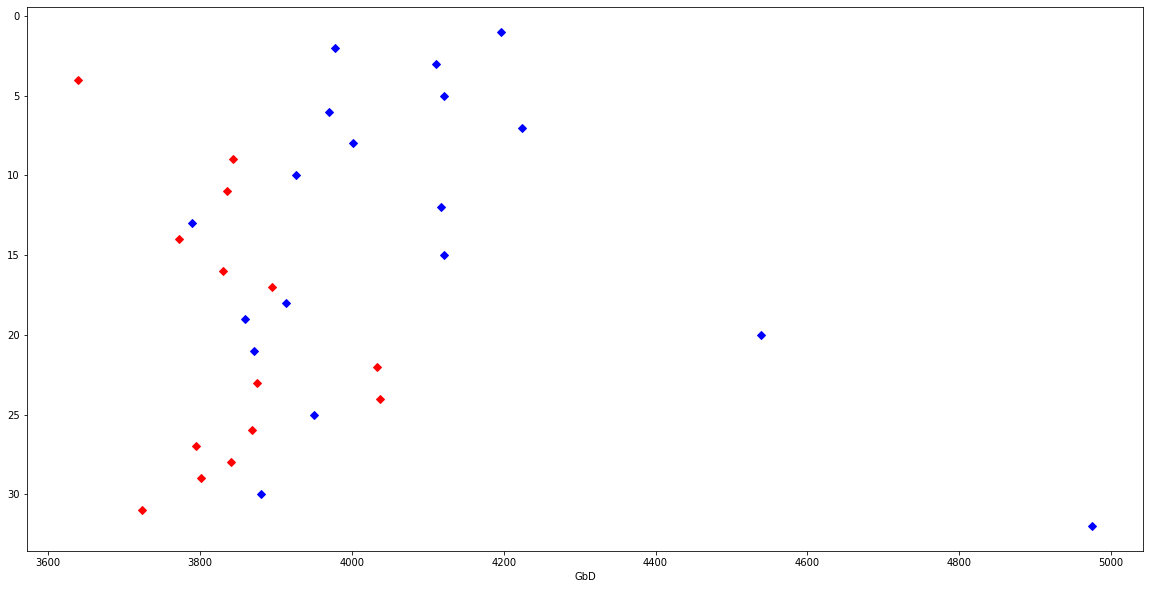

In [26]:
fig = plt.figure(figsize=(20,10))
tab = m_plus_grouped.loc[(m_plus_grouped['Foils/Dérives'] == 'D')]
tab = tab.set_index('GbD')
tab['Rank'].plot(style = 'D', color ='r')

tab = m_plus_grouped.loc[(m_plus_grouped['Foils/Dérives'] == 'F')]
tab = tab.set_index('GbD')
tab['Rank'].plot(style = 'D', color ='b').invert_yaxis();


We notice that boats with foils have travelled a longer distance, because blue points are more on the right of the graph. Of course, weather considerations (typically, wind force) can influence a skipper's choice, but the fact that boats with daggerboards tend to have a significant smaller gap between the travelled and the optimal distance indicates an overall relevant negative effect of foils on the choice of track. Also it is interseting to notice that the boat which travelled the most inefficient route is as of November 30th, the foiled boat "Charal" which underwent a serious structural damage and was forced to sail back to "Sables d'Olonne" and restart the race.    



## 4) Conclusion 

Combining the above graphs we conclude that when sailing in the Ocean foiled boats are slightly more efficient than classical daggerboards, but far less than it would be imaginable by simply considering the enormous loss in water drag. Indeed, the first graph shows that after the very first positions, the distribution of rankings is largely independent of the boat's type. It also reflects that already five participants have undergone serious structural damage (Amedeo, Béyou, Shiraishi, Troussel and Thomson) with two of them (Troussel and Thomson) forced to retire: all of them sailed foiled boats (this is reflected by more blue dots at the bottom of the plot). Similarly, the second graph shows that the true speed gain afforded by foils is around 1knt at an average speed of 20kts. This, combined with the third graph, shows that the speed gain is to a large extent, balanced by the longer route, resulting in a quite limited advantage of foiled boats against daggerboards ones.
